In [17]:
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np


Preprocessing

In [18]:
image_size = 224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
dataset = ImageFolder(root='../dataset', transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

indices = list(range(len(dataset)))
train_idx, testval_idx = train_test_split(indices, test_size=0.30, stratify=[dataset.targets[i] for i in indices], random_state=42)
val_idx, test_idx = train_test_split(testval_idx, test_size=0.50, stratify=[dataset.targets[i] for i in testval_idx], random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model creation

In [20]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# Freeze all layers (optional; you can unfreeze later for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match your number of classes
num_classes = 15  # your number of clothing categories
model.fc = nn.Linear(model.fc.in_features, num_classes)

C:\Users\tejas\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tejas\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\tejas/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 30.3MB/s]


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
image_size = 224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
import torch.optim as optim

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            correct += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation
        val_loss, val_acc = validate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"[{epoch+1}] Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

def validate(model, val_loader):
    model.eval()
    loss_sum, correct = 0.0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss_sum += loss.item() * images.size(0)
            correct += torch.sum(preds == labels)

    return loss_sum / len(val_loader.dataset), (correct.double() / len(val_loader.dataset)).item()


Train Model with 10 Epochs

In [25]:
train_model(model, train_loader, val_loader, epochs=10)

[1] Train Loss: 1.6917 Acc: 0.4777 | Val Loss: 1.3378 Acc: 0.5769
[2] Train Loss: 1.1264 Acc: 0.6528 | Val Loss: 1.1878 Acc: 0.6204
[3] Train Loss: 0.9990 Acc: 0.6802 | Val Loss: 1.0462 Acc: 0.6631
[4] Train Loss: 0.9113 Acc: 0.7040 | Val Loss: 1.0732 Acc: 0.6560
[5] Train Loss: 0.8720 Acc: 0.7141 | Val Loss: 1.0401 Acc: 0.6613
[6] Train Loss: 0.8320 Acc: 0.7291 | Val Loss: 1.0129 Acc: 0.6693
[7] Train Loss: 0.7688 Acc: 0.7482 | Val Loss: 1.0452 Acc: 0.6489
[8] Train Loss: 0.7729 Acc: 0.7427 | Val Loss: 0.9983 Acc: 0.6818
[9] Train Loss: 0.7258 Acc: 0.7663 | Val Loss: 1.0083 Acc: 0.6524
[10] Train Loss: 0.7292 Acc: 0.7589 | Val Loss: 1.0712 Acc: 0.6640


Plot accuracy

In [26]:
def plot_training(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

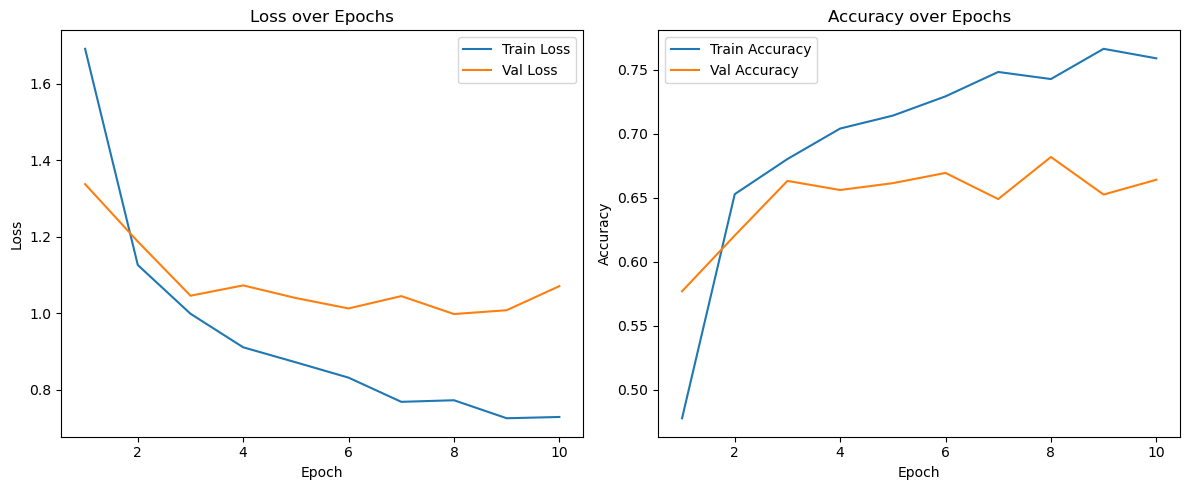

In [27]:
plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

Sample predictions

In [28]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(np.clip(inp, 0, 1))
    if title:
        plt.title(title)
    plt.axis('off')

def show_sample_predictions(model, loader, class_names, num_images=6):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                plt.figure(figsize=(3, 3))
                imshow(inputs[i].cpu(), title=f"Pred: {class_names[preds[i]]}, True: {class_names[labels[i]]}")
                images_shown += 1
                if images_shown >= num_images:
                    return

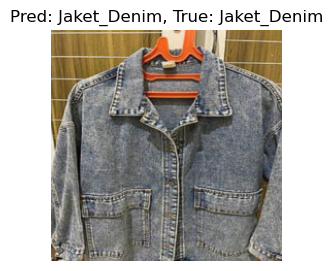

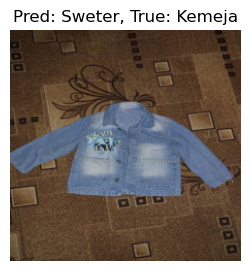

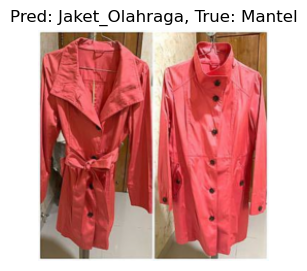

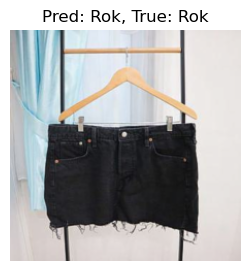

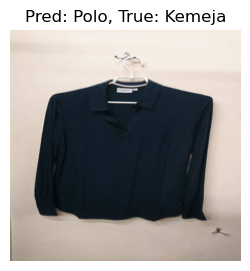

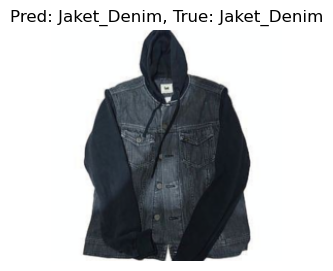

In [29]:
show_sample_predictions(model, val_loader, class_names)

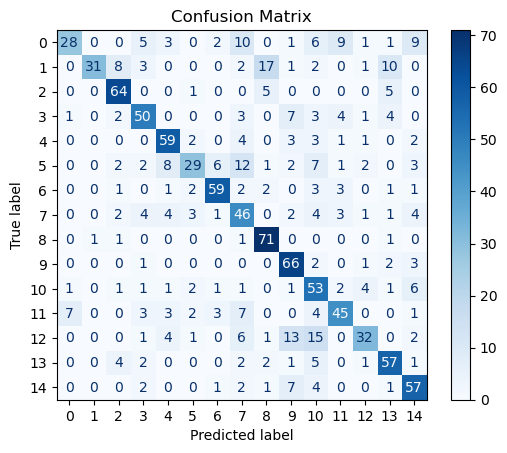

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you collected these during validation
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Evaluate and Save model

In [30]:
from sklearn.metrics import classification_report

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))

evaluate_model(model, test_loader)

                precision    recall  f1-score   support

        Blazer       0.79      0.35      0.48        75
Celana_Panjang       0.83      0.47      0.60        75
 Celana_Pendek       0.72      0.87      0.79        75
          Gaun       0.76      0.67      0.71        75
        Hoodie       0.72      0.76      0.74        75
         Jaket       0.72      0.44      0.55        75
   Jaket_Denim       0.75      0.76      0.75        75
Jaket_Olahraga       0.52      0.65      0.58        75
         Jeans       0.73      0.92      0.81        75
          Kaos       0.61      0.80      0.69        75
        Kemeja       0.50      0.79      0.61        75
        Mantel       0.65      0.71      0.68        75
          Polo       0.71      0.43      0.53        75
           Rok       0.74      0.79      0.76        75
        Sweter       0.67      0.71      0.69        75

      accuracy                           0.67      1125
     macro avg       0.69      0.67      0.66 

In [31]:
torch.save(model.state_dict(), "resnet_clothing_model.pth")